In [70]:
!pip install holidays -q
!pip install workalendar -q
!pip install fasttext -q

You should consider upgrading via the 'D:\conda\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'D:\conda\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'D:\conda\python.exe -m pip install --upgrade pip' command.


In [71]:
%%capture
import catboost
import pandas as pd
import numpy as np
import fasttext
import fasttext.util
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('bmh')

# Fasttext model downloading and reduction
#dlmode = fasttext.util.download_model("ru")
#model = "cc.ru.300.bin"
#ft_model = fasttext.load_model(model)
#fasttext.util.reduce_model(ft_model, 100)
#ft_model.save_model("cc.ru.100.bin")


In [72]:
file_name = r"../TenderHack_Москва_train_data.xlsx" 
columns = ['id', 'status', 'name', 'okpd2','kpgz','region','nmck','price','date','participans','bet','inn']

spgz_name = "../spgz_kpgz.xlsx"
df_kpgz = pd.read_excel(spgz_name)
df_kpgz = df_kpgz['КПГЗ']

df = pd.read_excel(file_name, header=None, names=columns, skiprows=1)
df['okpd2'] = df['okpd2'].fillna(0)
prod_df = df
prod_df = prod_df.drop('id', axis='columns')
prod_df.dtypes

status          object
name            object
okpd2           object
kpgz            object
region          object
nmck           float64
price          float64
date            object
participans      int64
bet              int64
inn             object
dtype: object

In [73]:
prod_df.head()

,status,name,okpd2,kpgz,region,nmck,price,date,participans,bet,inn
0,Завершена,СТУЛЬЯ УЧЕНИЧЕСКИЕ,0,01.06.01.03.01;01.06.01.03.01,Москва,596790.0,593806.05,2021-06-30 11:20:05.720,1,1,d8912494ba2edd3bfeba55206a78a0f5
1,Не состоялась,МЕДИЦИНСКИЕ РАСХОДНЫЕ МАТЕРИАЛЫ,0,01.02.10.50.33;01.02.10.43.05.01,Москва,4964.9,0.00,2022-10-04 09:16:04.770,0,0,237a5c57a66f02f8deb152e21f33863a
2,Завершена,Видеокарта Palit PCI-E,0,01.13.17.08,Москва,462000.0,311850.00,2021-07-01 13:23:09.177,6,65,040f1570117a744d529f4675f827a50f
3,Завершена,"ТОВАРЫ ИНФОРМАЦИОННО-ТЕХНОЛОГИЧЕСКИЕ, СРЕДСТВА...",0,01.13.11.03.02;01.13.04.04.06.05;01.10.04.04.0...,Москва,505555.0,460042.90,2021-03-16 10:42:20.810,6,18,c00c03dca0274fe43fc34e974434a927
4,Завершена,Пинцет острый,0,01.02.10.06.48.04,Москва,2000.0,1980.00,2022-05-26 11:04:42.597,2,2,cc997efa7a6742b6119a3c253a084e80


In [74]:
prod_df.nunique()

status              4
name            76947
okpd2            7621
kpgz            74161
region             10
nmck           124569
price          157474
date           244941
participans        36
bet               197
inn              3335
dtype: int64

In [75]:
"""
Завершена
Не состоялась
Снята с публикации
Активна"""

prod_df["status"].value_counts()
cleanup_nums = {"status": {"Завершена": 1, "Не состоялась": 0, 'Снята с публикации': 0, 'Активна': -1}}
prod_df = prod_df.replace(cleanup_nums)

prod_df.head()

print(prod_df["status"].unique())

[ 1  0 -1]


In [76]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for cat_var in ['inn']:
    prod_df[cat_var] = le.fit_transform(prod_df[cat_var])  
    
print(prod_df["inn"].unique())
print(prod_df["inn"].max())

[2808  443   56 ... 2689 1099  492]
3334


In [77]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for cat_var in ['region']:
    prod_df[cat_var] = le.fit_transform(prod_df[cat_var])  
    
print(prod_df["region"].unique())
print(prod_df["region"].max())

[2 4 5 7 9 6 1 0 3 8]
9


In [78]:
model = "../cc.ru.100.bin"

def get_names_embeddings(kpgzs: str, mapping: dict, ft_model) -> str:
    try:
        kpgzs = kpgzs.strip()
        result = ""
        for kpgz in kpgzs.split(";"):
            result+=" "+mapping[kpgz]
        return ft_model.get_sentence_vector(result.strip())
    except Exception as e:
        return ""

ft_model = fasttext.load_model(model)
mapping = {}
for kpgz, name in zip(df_kpgz.str.split().str[0], df_kpgz.str.split().str[1:].str.join(" ")):
    mapping[kpgz] = name

prod_df["kpgz"] = prod_df.kpgz.map(lambda x:get_names_embeddings(x, mapping=mapping, ft_model=ft_model))

In [79]:
prod_df.kpgz.head()

0    [0.16096573, 0.053907715, 0.09994291, -0.00717...
1    [0.19342507, 0.062566794, 0.07545345, -0.04950...
2    [0.22595255, 0.18388925, 0.19081077, -0.159544...
3    [0.16206501, 0.05943599, 0.13826528, -0.073260...
4    [0.14393458, 0.016421055, 0.014087511, 0.03256...
Name: kpgz, dtype: object

In [80]:
import holidays
from workalendar.europe import Russia

prod_df['date'] = pd.to_datetime(prod_df.date, format='%Y-%m-%d %H:%M:%S')
range_of_dates = pd.date_range("2022-01-01", "2023-12-31")
holidays = holidays.Russia(years=[2022, 2023]).items()

hdays = []
for day in holidays:
    hdays.append(day[0])

def season_from_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return '1'
    if date in seasons['summer']:
        return '2'
    if date in seasons['autumn']:
        return '3'
    else:
        return '4'

df_dt = pd.DataFrame()
df_dt['date_year'] = prod_df['date'].dt.year
df_dt['date_month'] = prod_df['date'].dt.month
df_dt['date_week'] = prod_df['date'].dt.isocalendar().week 
df_dt["date_weekend"] = df_dt["date_week"] >= 5
df_dt["date_weekend"] = df_dt["date_weekend"].astype(int)
df_dt['date_day'] = prod_df['date'].dt.day
df_dt['date_hour'] = prod_df['date'].dt.hour
df_dt['date_minute'] = prod_df['date'].dt.minute
df_dt['date_dayofweek'] = prod_df['date'].dt.dayofweek
df_dt['date_quarter'] = prod_df['date'].dt.quarter
#df_dt["delta_to_holiday"] = df['date'].isin(hdays)
df_dt["is_holiday"] = prod_df['date'].isin(hdays)
df_dt["is_holiday"] = df_dt["is_holiday"].astype(int)
df_dt['date_season'] = prod_df.date.map(season_from_date)
prod_df = pd.concat([prod_df, df_dt], axis=1)
prod_df = prod_df.drop('date', axis='columns')
prod_df

,status,name,okpd2,kpgz,region,nmck,price,participans,bet,inn,...,date_month,date_week,date_weekend,date_day,date_hour,date_minute,date_dayofweek,date_quarter,is_holiday,date_season
0,1,СТУЛЬЯ УЧЕНИЧЕСКИЕ,0,"[0.16096573, 0.053907715, 0.09994291, -0.00717...",2,596790.0,593806.05,1,1,2808,...,6,26,1,30,11,20,2,2,0,4
1,0,МЕДИЦИНСКИЕ РАСХОДНЫЕ МАТЕРИАЛЫ,0,"[0.19342507, 0.062566794, 0.07545345, -0.04950...",2,4964.9,0.00,0,0,443,...,10,40,1,4,9,16,1,4,0,4
2,1,Видеокарта Palit PCI-E,0,"[0.22595255, 0.18388925, 0.19081077, -0.159544...",2,462000.0,311850.00,6,65,56,...,7,26,1,1,13,23,3,3,0,4
3,1,"ТОВАРЫ ИНФОРМАЦИОННО-ТЕХНОЛОГИЧЕСКИЕ, СРЕДСТВА...",0,"[0.16206501, 0.05943599, 0.13826528, -0.073260...",2,505555.0,460042.90,6,18,2476,...,3,11,1,16,10,42,1,1,0,4
4,1,Пинцет острый,0,"[0.14393458, 0.016421055, 0.014087511, 0.03256...",2,2000.0,1980.00,2,2,2639,...,5,21,1,26,11,4,3,2,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246757,0,Червячный хомут FORTISFLEX 110-130,0,"[0.19502488, 0.08221254, 0.1079145, -0.158651,...",2,1000.0,0.00,0,0,2484,...,3,13,1,30,12,23,2,1,0,4
246758,0,"Маскировочная сеть, ""Стандарт"", МС1-6, 3х6 м",0,"[0.283096, 0.05377666, 0.07069133, -0.20894223...",2,60000.0,0.00,0,0,2730,...,10,40,1,3,9,42,0,4,0,4
246759,0,"ТРАНСПОРТНЫЕ СРЕДСТВА, РАСХОДНЫЕ МАТЕРИАЛЫ И З...",0,"[0.19734564, 0.059326775, 0.091283455, -0.1787...",2,402582.6,0.00,0,0,1261,...,4,16,1,20,9,13,1,2,0,4
246760,1,БЛАНКИ,0,"[0.33548427, 0.054563295, 0.12697892, -0.14395...",2,18600.0,10500.00,5,9,2842,...,10,43,1,28,11,47,4,4,0,4


### Создаем фичи из пространства векторов fasttext

In [146]:
new_df = prod_df
vecs = pd.DataFrame([list(x) for x in new_df.kpgz.to_numpy()])
new_df = pd.concat([new_df, vecs], axis=1)
new_df = new_df.drop('kpgz', axis = 1)
new_df = new_df.drop('name', axis='columns')
new_df = new_df.drop('okpd2', axis = 1)
new_df

,status,region,nmck,price,participans,bet,inn,date_year,date_month,date_week,...,90,91,92,93,94,95,96,97,98,99
0,1,2,596790.0,593806.05,1,1,2808,2021,6,26,...,0.013466,-0.090337,0.051722,-0.061925,0.030060,0.030791,0.081871,0.032043,-0.052415,-0.019944
1,0,2,4964.9,0.00,0,0,443,2022,10,40,...,-0.023313,-0.019197,0.079284,-0.020760,0.055079,0.076258,0.047189,0.043398,-0.004118,-0.005981
2,1,2,462000.0,311850.00,6,65,56,2021,7,26,...,0.065594,-0.050499,0.000987,-0.045552,0.048822,0.039462,-0.013432,0.111932,-0.013779,-0.042188
3,1,2,505555.0,460042.90,6,18,2476,2021,3,11,...,0.070665,-0.052017,-0.006147,-0.053908,0.047077,-0.002517,-0.033711,-0.003724,-0.027799,-0.017508
4,1,2,2000.0,1980.00,2,2,2639,2022,5,21,...,0.028585,-0.060793,0.040318,-0.143009,0.093545,0.077735,0.030326,0.021410,0.002746,0.024787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246757,0,2,1000.0,0.00,0,0,2484,2022,3,13,...,0.028429,-0.012718,0.033383,-0.039144,-0.019265,0.079498,0.002019,0.039995,-0.016166,0.013183
246758,0,2,60000.0,0.00,0,0,2730,2022,10,40,...,0.147485,-0.059466,0.037760,-0.066452,0.082637,0.051875,-0.011917,0.031013,-0.069107,-0.045121
246759,0,2,402582.6,0.00,0,0,1261,2021,4,16,...,0.068774,-0.037366,0.037198,-0.031401,0.018510,0.044169,-0.026488,0.005995,0.008186,0.007994
246760,1,2,18600.0,10500.00,5,9,2842,2022,10,43,...,-0.013858,-0.030848,0.012180,-0.095158,0.082351,0.079310,-0.018566,-0.040581,-0.058793,-0.011701


In [147]:
s = new_df.dtypes == "float64"
for ind in s[s].index:
    new_df.loc[:,ind] = new_df.loc[:,ind].astype(str)


# new_df = new_df.iloc[:,~new_df.columns.duplicated()]
# new_df

count    246762.000000
mean          3.240199
std           3.084245
min           0.000000
25%           1.000000
50%           2.000000
75%           5.000000
max          39.000000
Name: participans, dtype: float64


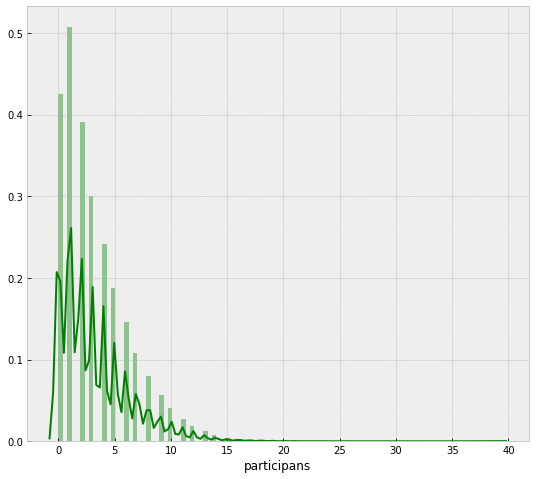

In [148]:
print(new_df['participans'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(new_df['participans'], color='g', bins=100, hist_kws={'alpha': 0.4});

### Нормализуем данные в датасете

In [161]:
import pandas as pd
from sklearn import preprocessing

x = new_df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
new_df = pd.DataFrame(x_scaled, columns=new_df.columns, index=new_df.index)
new_df = new_df.replace(np.nan, 0)
new_df

,status,region,nmck,price,participans,bet,inn,date_year,date_month,date_week,...,90,91,92,93,94,95,96,97,98,99
0,1.0,0.222222,0.032704,0.032704,0.025641,0.005025,0.842232,0.0,0.454545,0.48,...,0.461192,0.445847,0.610999,0.486402,0.547123,0.502921,0.539971,0.647199,0.322071,0.556442
1,0.5,0.222222,0.000272,0.000000,0.000000,0.000000,0.132873,1.0,0.818182,0.76,...,0.386953,0.662697,0.670850,0.579222,0.602851,0.610812,0.468305,0.676760,0.429625,0.593738
2,1.0,0.222222,0.025318,0.017175,0.153846,0.326633,0.016797,0.0,0.545455,0.48,...,0.566413,0.567281,0.500826,0.523321,0.588915,0.523498,0.343037,0.855162,0.408111,0.497024
3,1.0,0.222222,0.027705,0.025337,0.153846,0.090452,0.742651,0.0,0.181818,0.18,...,0.576647,0.562654,0.485334,0.504480,0.585028,0.423883,0.301133,0.554093,0.376889,0.562948
4,1.0,0.222222,0.000110,0.000109,0.051282,0.010050,0.791542,1.0,0.363636,0.38,...,0.491709,0.535903,0.586234,0.303572,0.688531,0.614318,0.433458,0.619519,0.444912,0.675926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246757,0.5,0.222222,0.000055,0.000000,0.000000,0.000000,0.745051,1.0,0.181818,0.22,...,0.491396,0.682446,0.571176,0.537770,0.437255,0.618502,0.374965,0.667899,0.402795,0.644931
246758,0.5,0.222222,0.003288,0.000000,0.000000,0.000000,0.818836,1.0,0.818182,0.76,...,0.731710,0.539949,0.580680,0.476196,0.664235,0.552952,0.346168,0.644519,0.284900,0.489189
246759,0.5,0.222222,0.022062,0.000000,0.000000,0.000000,0.378224,0.0,0.272727,0.28,...,0.572831,0.607313,0.579459,0.555230,0.521395,0.534668,0.316059,0.579394,0.457026,0.631068
246760,1.0,0.222222,0.001019,0.000578,0.128205,0.045226,0.852430,1.0,0.818182,0.82,...,0.406039,0.627182,0.525133,0.411469,0.663598,0.618055,0.332429,0.458149,0.307869,0.578460


In [111]:
new_df.to_csv('test.csv')

In [113]:
new_df['participans'].unique()

array([0.02564103, 0.        , 0.15384615, 0.05128205, 0.20512821,
       0.17948718, 0.07692308, 0.48717949, 0.12820513, 0.1025641 ,
       0.23076923, 0.41025641, 0.25641026, 0.56410256, 0.35897436,
       0.30769231, 0.28205128, 0.38461538, 0.33333333, 0.58974359,
       0.43589744, 0.46153846, 0.53846154, 0.82051282, 0.51282051,
       0.76923077, 0.74358974, 0.64102564, 0.61538462, 0.71794872,
       0.84615385, 0.66666667, 0.87179487, 0.69230769, 1.        ,
       0.79487179])

In [162]:
df_num = new_df.select_dtypes(include = ['float64', 'int64'])
df_num_corr = df_num.corr()['participans']
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with participans:\n{}".format(len(golden_features_list), golden_features_list))

There is 2 strongly correlated values with participans:
participans    1.000000
bet            0.749631
Name: participans, dtype: float64


### Пробуем предсказать статус закупки

In [170]:
X = new_df.drop(["participans", "price", "status", "bet"], axis=1)
y = new_df["price"]

# Cat features

In [60]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116]


In [171]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [172]:
model_CBR = CatBoostRegressor(iterations=500, max_depth=5, learning_rate=0.05, )
model_CBR.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

print('CatBoostRegressor model is fitted: ' + str(model_CBR.is_fitted()))
print('CatBoostRegressor model parameters:')
print(model_CBR.get_params())

CatBoostRegressor model is fitted: True
CatBoostRegressor model parameters:
{'iterations': 500, 'learning_rate': 0.05, 'loss_function': 'RMSE', 'max_depth': 5}


Text(0.5, 1.0, 'Feature Importance')

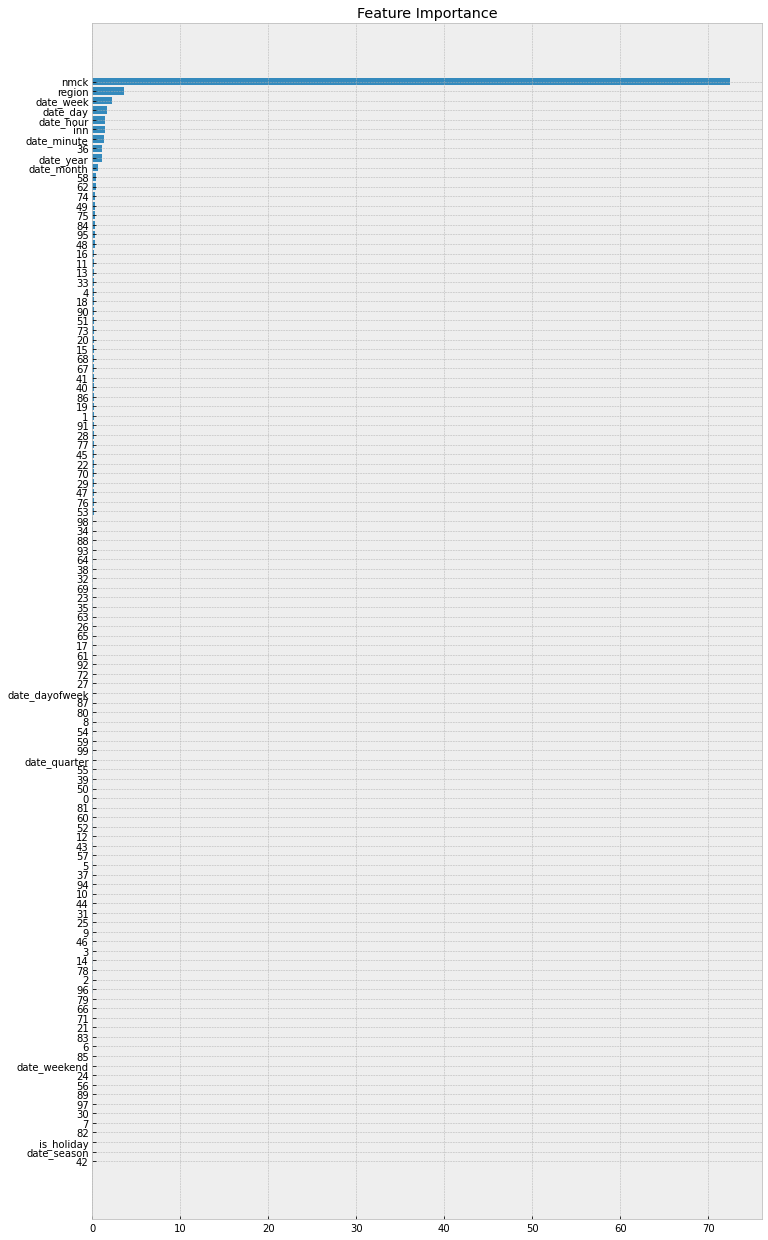

In [173]:
feature_importance = model_CBR.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 22))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

Text(0.5, 1.0, 'Permutation Importance')

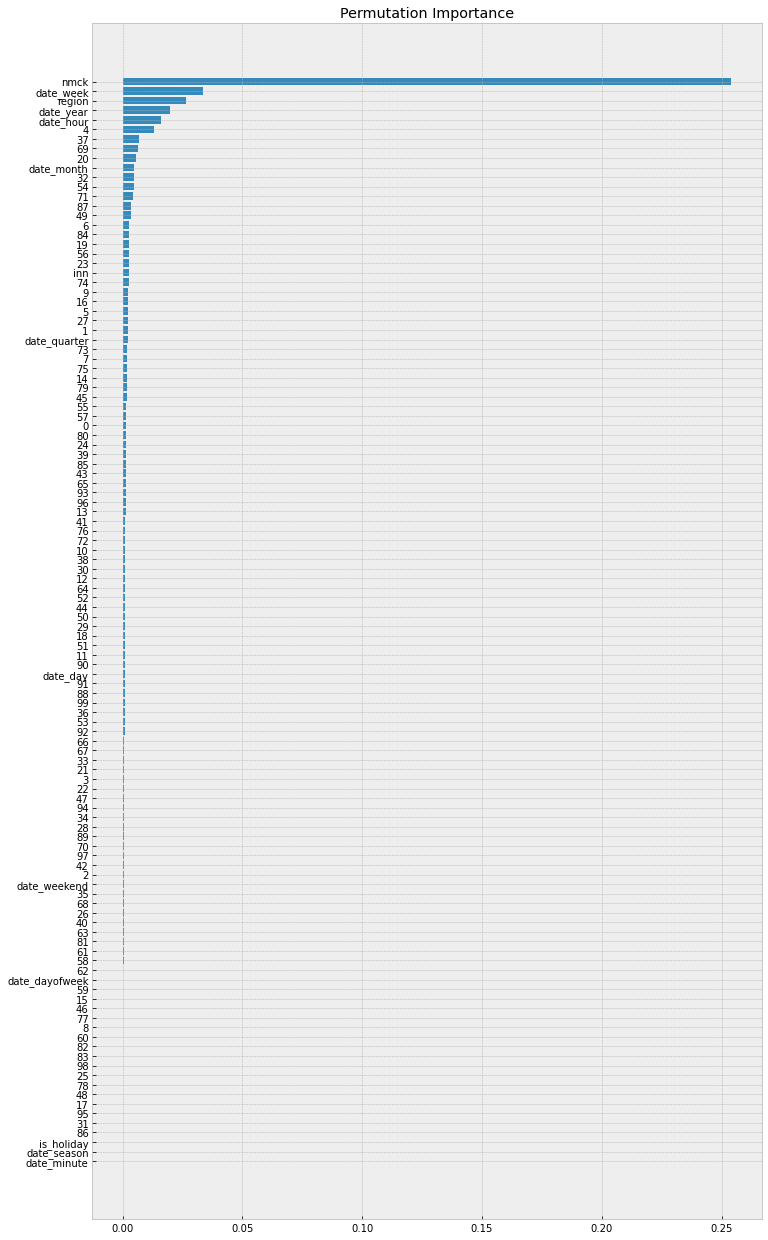

In [167]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model_CBR, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 22))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')

In [144]:
from sklearn.model_selection import GridSearchCV


params = {'depth':[3,1,2,6,4,5,7,8,9,10],
              'iterations':[250,100,500,1000],
              'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3],
              'l2_leaf_reg':[3,1,5,10,100],
              'border_count':[32,5,10,20,50,100,200],
              'bagging_temperature':[0.03,0.09,0.25,0.75],
              'random_strength':[0.2,0.5,0.8],
              'max_ctr_complexity':[1,2,3,4,5] }


model = CatBoostRegressor(task_type="GPU")
grid = model.grid_search(params,
                                        X=X_train,
                                        y=y_train,
                                        cv=5,
                                        partition_random_seed=3,
                                        stratified=True)
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

# model_CBR_grid = CatBoostRegressor(task_type="GPU")

# parameters = {    'depth'         : [6, 8, 10],
#                   #'learning_rate' : [0.01, 0.05, 0.1],
#                   'iterations'    : [100, 500, 1000]
#              }

# grid = GridSearchCV(estimator=model_CBR_grid, param_grid = parameters, cv = 2, n_jobs=-1)
# grid.fit(X_train, y_train)

# print(" Results from Grid Search " )
# print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
# print("\n The best score across ALL searched params:\n", grid.best_score_)
# print("\n The best parameters across ALL searched params:\n", grid.best_params_)

ModuleNotFoundError: No module named 'sklearn.grid_search'

In [110]:
# from catboost import CatBoostClassifier

# clf = CatBoostClassifier(
#     iterations=5, 
#     learning_rate=0.1, 
#     #loss_function='CrossEntropy'
# )


# clf.fit(X_train, y_train, 
#         #cat_features=cat_features, 
#         eval_set=(X_test, y_test), 
#         verbose=False
# )

# print('CatBoost model is fitted: ' + str(clf.is_fitted()))
# print('CatBoost model parameters:')
# print(clf.get_params())

CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/target/target_converter.cpp:226: Unknown class label: "0.820513"

In [69]:
catboost.metrics.MAE?

Init signature: catboost.metrics.MAE(**kwargs)
Docstring:     
Builtin metric: 'MAE'
Parameters:
    delta = 1e-06 (default value)
    alpha = 0.5 (default value)
    use_weights = True (default value)
    hints = '' (default value)
File:           d:\conda\lib\site-packages\catboost\metrics.py
Type:           _MetricGenerator
Subclasses:     


### предсказание mean_absolute_error 

In [180]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn import metrics

#X_train, X_test, y_train, y_test
predicted_y = model_CBR.predict(X_test)
#print("r2_score", metrics.r2_score(y_test, predicted_y))
print("mean_absolute_error", mean_absolute_error(y_test, predicted_y))

mean_absolute_error 0.0024620457671754438


<AxesSubplot:xlabel='price'>

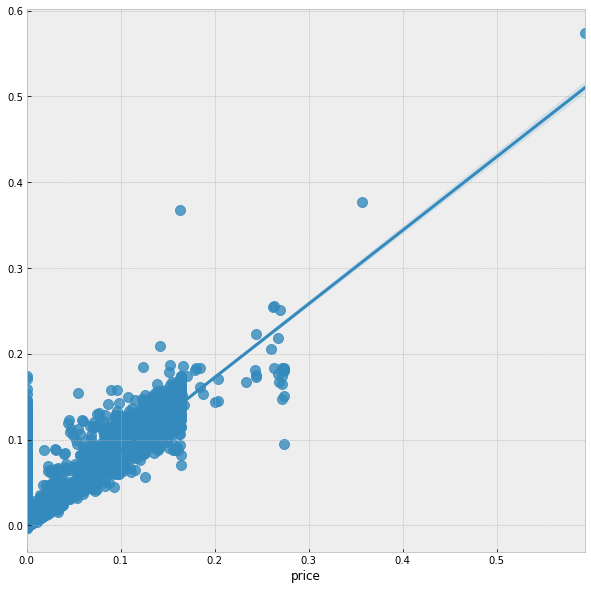

In [181]:
plt.figure(figsize=(10,10))
sns.regplot(y_test, predicted_y, fit_reg=True, scatter_kws={"s": 100})